## 1. Complementary filter (Euler angle integration + Accelerometer attitude)

- Gyroscope의 angular rate를 누적하여 구한 자세와 Accelerometer의 출력을 사용하여 구한 자세 정보를 fusion하는 filter 알고리즘
- Gyroscope의 측정치인 angular rate $[p,q,r]^T$와 가속도계에서 측정된 가속도 정보를 사용한 자세정보 $[\phi, \theta, \psi]^T$를 사용하여 자세 추정
- Euler angle에 대한 Euler angular rate($z_{t,\dot \phi, \dot \theta,\dot \psi}$)는 다음과 같이 나타낼 수 있다.

$$
z=
\begin{bmatrix}
\dot \phi\\
\dot \theta\\
\dot \psi\\
\end{bmatrix}
=
\begin{bmatrix}
1&\sin \phi \tan \theta& \cos \phi \tan \ \theta\\
0& \cos\phi& -\sin\phi\\
0&\sin\phi/\cos\theta&\cos\phi/cos\theta
\end{bmatrix}
\begin{bmatrix}
p\\
q\\
r\\
\end{bmatrix}
$$

- 가장 간단하게 자세정보는 Euler angular rate를 매 sampling period마다 이전의 자세 정보와 반복적으로 더해서 구할 수 있다.

$$
\begin{aligned}
\hat \phi_t &=
{\left(  \hat \phi_{t-1} + T_s z_{t, \dot \phi} \right)}\\
\hat \theta_t &= 
{\left(\hat \theta_{t-1} + T_s z_{t, \dot \theta} \right)}\\
\hat \psi_t &=
{\left(\hat \psi_{t-1} + T_s z_{t, \dot \psi} \right)}
\end{aligned}\\
$$

- 이 방법의 문제점은 gyroscope의 측정 오차에 의해 시간이 지남에 따라 추정된 자세 정보의 오차가 매우 커진다는 것이다.
- 자세정보의 오차는 $n\sigma^2T_s^2$의 크기로 커진다. 
- 여기서 n은 sample period가 몇 번 수행되었는지를 의미하고 $\sigma^2$는 gyroscope의 noise variance를 의미 한다.

- 자세정보를 구할 수 있는 또 다른 방법은 가속도계의 정보를 사용하는 것이다.
- 가속도계의 측정치 $[a_x, a_y, a_z]^T$는 다음과 같이 다양한 정보를 포함하고 있다.

$$
\begin{bmatrix}
a_x\\
a_y\\
a_z
\end{bmatrix}
=
\begin{bmatrix}
\dot u\\
\dot v\\
\dot w
\end{bmatrix}
+
\begin{bmatrix}
0&w&-v\\
-w&0&u\\
-v&-u&0
\end{bmatrix}
\begin{bmatrix}
p\\
q\\
r
\end{bmatrix}
+
g\begin{bmatrix}
\sin\theta\\
-\cos\theta\sin\phi\\
-\cos\theta\cos\phi
\\
\end{bmatrix}
$$

- 여기서 $[\dot u, \dot v, \dot w]^T$는 이동 가속도, $[u, v, w]^T$는 이동 속도를 의미한다.
- 시스템이 일정한 속도로 이동하거나 정지해 있다면,

$$
\dot u = \dot v = \dot w =0
$$
- 자세의 변화가 없다면,
$$
p=q=r=0
$$

- 따라서 다음과 같이 간단하게 정리된다.

$$
\begin{bmatrix}
a_x\\
a_y\\
a_z
\end{bmatrix}
=
g\begin{bmatrix}
\sin\theta\\
-\cos\theta\sin\phi\\
-\cos\theta\cos\phi
\\
\end{bmatrix}$$

- 여기서 $g$는 중력가속도를 의미하며 이 항은 Rotation matrix에 down 방향의 중력을 곱한 형태가 된다.

$$
g
\begin{bmatrix}
\sin\theta\\
-\cos\theta\sin\phi\\
-\cos\theta\cos\phi
\\
\end{bmatrix}
=
R
\begin{bmatrix}
0\\
0\\
-g
\end{bmatrix}
$$

- 측정된 가속도 정보를 이용한 Euler angle의 추정은 간단하게 구할 수 있다.

$$
\begin{aligned}
\phi &= \tan^{-1}\frac{a_y}{a_z}=\sin^{-1} \frac{-a_y}{g\cos \theta}\\
\theta &= \tan^{-1} \frac{-a_x}{\sqrt{(a_y^2+a_z^2)}}=\sin^{-1}\frac{a_x}{g}\\
\psi &= 0\\\\
where,\\ g &=  9.79641227572363 m/s^2\\
&\approx 9.81 m/s^2
\end{aligned}
$$

- 가속도 정보를 사용한 자세 추정은 시간에 따른 에러의 누적이 없는 장점이 있다. 
- 따라서 gyroscope와 각 속도계의 출력을 적절히 섞어 자세를 추정 할 수 있는데, 이러한 자세 추정 filter를 complementary filter라 한다.
- Gyroscope의 측정 노이즈가 가속도의 측정 노이즈에 비해 더 작고, 응답 속도 또한 빠르기 때문에 자세 정보를 추정하는데 gyroscope의 출력을 누적하되, 가속도계에서 구한 자세정보를 이용할 수 있다.
- 이것은 recursive하게 평균을 구할 때 weighted sum의 형태로 구하는 것과 동일하다.

$$
\begin{aligned}
\hat \phi_t &=
\frac{\tau}{\tau + T_s}{\left(  \hat \phi_{t-1} + T_s z_{t, \dot \phi} \right)} + \frac{T_s}{\tau + Ts}{z_{t, \phi}}\\
\hat \theta_t &= 
\frac{\tau}{\tau + T_s}{\left(  \hat \theta_{t-1} + T_s z_{t, \dot \theta} \right)} + \frac{T_s}{\tau + Ts}{z_{t, \theta}}\\
\hat \psi_t &=
\frac{\tau}{\tau + T_s}{\left(\hat \psi_{t-1} + T_s z_{t, \dot \psi} \right)} + \frac{T_s}{\tau + Ts}{z_{t, \psi}}
\end{aligned}
$$



# Program

In [1]:
import numpy as np
from scipy.io import loadmat
from math import sin, cos, tan
import matplotlib.pyplot as plt
from navimath import *

In [2]:
# Dataset selection
# f_number 
# 1: Example data provided by Magdwich
# 2: Real IMU data provided by Witmotion 
# 3: Real IMU data provided by Understanding Kalman filter
f_number = 3

if f_number == 1:
    # Example Data
    ExData1 = loadmat('..\Data\ExampleData.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    time = ExData1['time']
    
    # System model noise covariance
    Q = np.zeros((3,3))
    Q[0, 0] = 0.01     # Roll angle uncertainty
    Q[1, 1] = 0.01     # Pitch angle uncertainty
    Q[2, 2] = 1     # Yaw angle uncertainity    

    # Measurement noise covariance
    R = np.zeros((3,3))
    R[0, 0] = 10      # Accelerometer measurement uncertainty
    R[1, 1] = 10      # Accelerometer measurement uncertainty
    R[2, 2] = 10     # Magnetometer measurement uncertainity    
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = time[1]-time[0]
    totalLen = Accelerometer.shape[0]
    
elif f_number ==2:

    # Example Data
    ExData1 = loadmat('..\Data\WitMotion_IMU_Data.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    Euler_Truth = ExData1['Euler']
        
    # System model noise covariance
    Q = np.zeros((3,3))
    Q[0, 0] = 100     # Roll angle uncertainty
    Q[1, 1] = 100     # Pitch angle uncertainty
    Q[2, 2] = 1000     # Yaw angle uncertainity

    # Measurement noise covariance
    R = np.zeros((3,3))
    R[0, 0] = 10      # Accelerometer measurement uncertainty
    R[1, 1] = 10      # Accelerometer measurement uncertainty
    R[2, 2] = 10     # Magnetometer measurement uncertainity
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = 1
    totalLen = Accelerometer.shape[0]
    
else:
    ArsAccel = loadmat('..\Data\ArsAccel.mat')
    ArsGyro = loadmat('..\Data\ArsGyro.mat')
    
    Gyroscope = np.zeros((41500, 3))
    Accelerometer = np.zeros((41500, 3))
    
    Gyroscope[:,0] = ArsGyro['wx'][:,0]
    Gyroscope[:,1] = ArsGyro['wy'][:,0]
    Gyroscope[:,2] = ArsGyro['wz'][:,0]
    
    Accelerometer[:,0] = ArsAccel['fx'][:,0]
    Accelerometer[:,1] = ArsAccel['fy'][:,0]
    Accelerometer[:,2] = ArsAccel['fz'][:,0]    
    
    Q = np.array([[0.0001, 0, 0],
              [0, 0.0001, 0],
              [0, 0, 1]])
    R = 10 * np.eye(3)
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = 0.01
    totalLen = 41500

In [3]:
# State
n_x = 3

# 변수 초기화
fusion_enable = True  # Complementary fusion enable
tau = 0.3             # Complementary filer constant

# Complementary filter 결과 
mu = np.zeros((n_x))
mu_hist = np.zeros((totalLen,n_x))

# measurement update에 사용되는 measurement를 위한 변수
z_hist = np.zeros((totalLen, n_x))

# Sensor fusion 결과 확인을 위한 보조 변수들 
angle_accum = np.zeros((n_x))
angle_accum_hist = np.zeros((totalLen, n_x))


for i in range(totalLen):
    
    # initialization
    if i == 0:                
        
        mu = mu0    
        attitude = mu0
    
    # Accelerometer 및 magnatometer를 사용한 attitude measurement
    if f_number == 3:
        z = attitudemeasure(mu, 1, Accelerometer[i,:])
    else:
        z = attitudemeasure(mu, 2, Accelerometer[i,:], Magnetometer[i,:])   
        
        
    z_dot  = gyro_angular_rate(mu, Gyroscope[i,:])
        
    mu = (tau/(tau+Ts))*(mu  + z_dot *Ts) + (Ts/(tau+Ts))*(z)        
    
    mu_hist[i,:] = mu
    z_hist[i,:] = z
    
    
    # 결과 비교를 Gyroscope 출력을 누적하여 자세를 구하는 코드
    angle_accum = Euler_accum(angle_accum, Gyroscope[i,:], Ts)    # Euler angle accumulation ==> 확인용 코드
    angle_accum_hist[i,:] = angle_accum
    
    

Text(0.5, 1.0, 'Attitude by accelerometer')

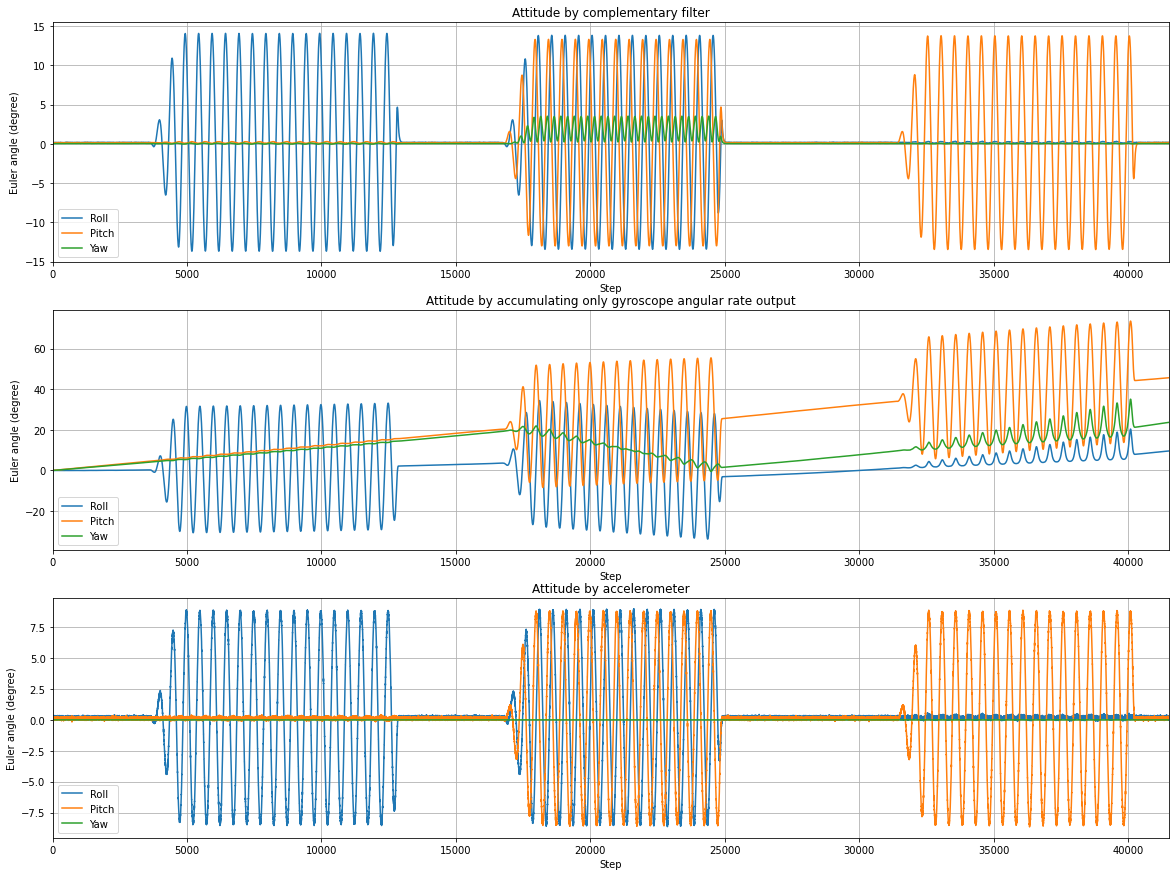

In [4]:
plt.figure(figsize=(20,15))

# Result plotting
plt.subplot(3,1,1)    
plt.plot(np.rad2deg(mu_hist))
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by complementary filter')

plt.subplot(3,1,2)    
plt.plot(np.rad2deg(angle_accum_hist))
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by accumulating only gyroscope angular rate output')

plt.subplot(3,1,3)    
plt.plot(np.rad2deg(z_hist))
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])

if f_number == 3:
    title = 'Attitude by accelerometer'    
else:
    title = 'Attitude by accelerometer and magnetometer'

plt.title(title)
  